## Importation des packages

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

##  Chargement et description des données

In [ ]:
# Chargement des données
data = pd.read_csv('Data\DATA SET-1.csv')

# Description initiale
print(f"Dimensions du dataset: {data.shape}")
print("\nAperçu des données:")
print(data.head())
print("\nInformations sur les colonnes:")
print(data.info())
print("\nStatistiques descriptives:")
print(data.describe())

## Analyse exploratoire (EDA)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données (remplacez par votre propre chargement si nécessaire)
# data = pd.read_csv('DATA SET-1.csv')

# 1. Analyse des variables cibles
target_vars = ['Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Biopsy']

plt.figure(figsize=(14, 10))
for i, var in enumerate(target_vars, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=var, data=data, palette='viridis')
    
    # Ajout des pourcentages
    total = len(data[var])
    for p in plt.gca().patches:
        height = p.get_height()
        plt.gca().text(p.get_x()+p.get_width()/2.,
                       height + 10,
                       '{:1.1f}%'.format(height/total*100),
                       ha='center')
    
    plt.title(f'Distribution de {var}', fontsize=12, pad=10)
    plt.xlabel('')
    plt.ylabel('Nombre de cas', fontsize=10)

plt.suptitle('Distribution des Variables Cibles', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# 2. Analyse des corrélations
plt.figure(figsize=(18, 15))

# Sélectionner uniquement les colonnes numériques
numeric_cols = data.select_dtypes(include=['number']).columns
corr_matrix = data[numeric_cols].corr()

# Masquer la moitié supérieure pour éviter la redondance
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            mask=mask,
            cmap='coolwarm', 
            center=0,
            annot=True, 
            fmt=".2f",
            linewidths=.5,
            cbar_kws={"shrink": .8})

plt.title('Matrice de Corrélation des Variables Numériques', pad=20, fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# 3. Distribution d'âge
plt.figure(figsize=(12, 6))
ax = sns.histplot(data['Age'], bins=30, kde=True, color='skyblue')

# Ajouter des annotations
mean_age = data['Age'].mean()
median_age = data['Age'].median()
ax.axvline(mean_age, color='red', linestyle='--', linewidth=1.5)
ax.axvline(median_age, color='green', linestyle='-', linewidth=1.5)

plt.title(f'Distribution des Âges\n(Moyenne: {mean_age:.1f} ans, Médiane: {median_age:.1f} ans)', fontsize=14)
plt.xlabel('Âge', fontsize=12)
plt.ylabel('Nombre de patients', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.legend({'Moyenne':mean_age, 'Médiane':median_age})
plt.show()

# 4. Analyse des valeurs manquantes
missing_values = data.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]

if not missing_values.empty:
    print("\nValeurs manquantes par colonne:")
    print(missing_values)
    
    # Visualisation des valeurs manquantes
    plt.figure(figsize=(10, 6))
    missing_values.plot(kind='barh', color='coral')
    plt.title('Valeurs Manquantes par Colonne', fontsize=14)
    plt.xlabel('Nombre de valeurs manquantes', fontsize=12)
    plt.ylabel('Colonnes', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.show()
else:
    print("\nAucune valeur manquante dans le dataset.")

## Prétraitement des données

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# 1. Nettoyage initial des données - remplacer les valeurs problématiques
data = data.replace('?', np.nan)
data = data.replace(' ', np.nan)  # au cas où il y aurait des espaces

# 2. Conversion des colonnes en types numériques quand c'est possible
for col in data.columns:
    # On essaie de convertir en numérique sauf pour les colonnes cibles
    if col not in ['Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Biopsy']:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# 3. Gestion des valeurs manquantes
# Séparation des colonnes numériques et catégorielles
num_cols = data.select_dtypes(include=['number']).columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns

# Imputation pour les variables numériques
if len(num_cols) > 0:
    num_imputer = SimpleImputer(strategy='median')
    data[num_cols] = num_imputer.fit_transform(data[num_cols])

# Imputation pour les variables catégorielles
if len(cat_cols) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])

# 4. Vérification finale des types
print("\nVérification des types après nettoyage:")
print(data.dtypes)

# 5. Normalisation des données
try:
    scaler = StandardScaler()
    X = data.drop(target_vars, axis=1)
    
    # On ne standardise que les colonnes numériques
    numeric_features = X.select_dtypes(include=['number']).columns
    X_numeric = X[numeric_features]
    
    y = data[target_vars[0]]  # Cible principale
    
    if not X_numeric.empty:
        X_scaled = scaler.fit_transform(X_numeric)
        print("\nNormalisation réussie !")
        print(f"Dimensions des données normalisées : {X_scaled.shape}")
    else:
        print("\nAucune colonne numérique à normaliser")
        X_scaled = X.values  # Utilisation des données brutes si pas de normalisation possible
        
except Exception as e:
    print(f"\nErreur lors de la normalisation : {str(e)}")
    print("Voici les types de données dans X:")
    print(X.dtypes)

## Division des données

In [10]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f"Taille de l'ensemble d'entraînement: {X_train.shape}")
print(f"Taille de l'ensemble de test: {X_test.shape}")

Taille de l'ensemble d'entraînement: (601, 32)
Taille de l'ensemble de test: (258, 32)


## Construction des modèles

### Modèles de Machine Learning

In [15]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# SVM
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

# Régression Logistique
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

### Modèle de Deep Learning

In [12]:
# Construction du modèle
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compilation
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Entraînement
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=50, 
                    batch_size=32, 
                    verbose=1)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7210 - loss: 0.6486 - val_accuracy: 0.9729 - val_loss: 0.3679
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9745 - loss: 0.3194 - val_accuracy: 0.9767 - val_loss: 0.2376
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9848 - loss: 0.1791 - val_accuracy: 0.9767 - val_loss: 0.1728
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9857 - loss: 0.1183 - val_accuracy: 0.9767 - val_loss: 0.1398
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9834 - loss: 0.0874 - val_accuracy: 0.9767 - val_loss: 0.1204
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9857 - loss: 0.0648 - val_accuracy: 0.9806 - val_loss: 0.1114
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9755 - loss: 0.0549 - val_accuracy: 0.9806 - val_loss: 0.1067
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9802 - loss: 0.0542 - val_accuracy: 0.9806 - v

## Visualisation de l'apprentissage

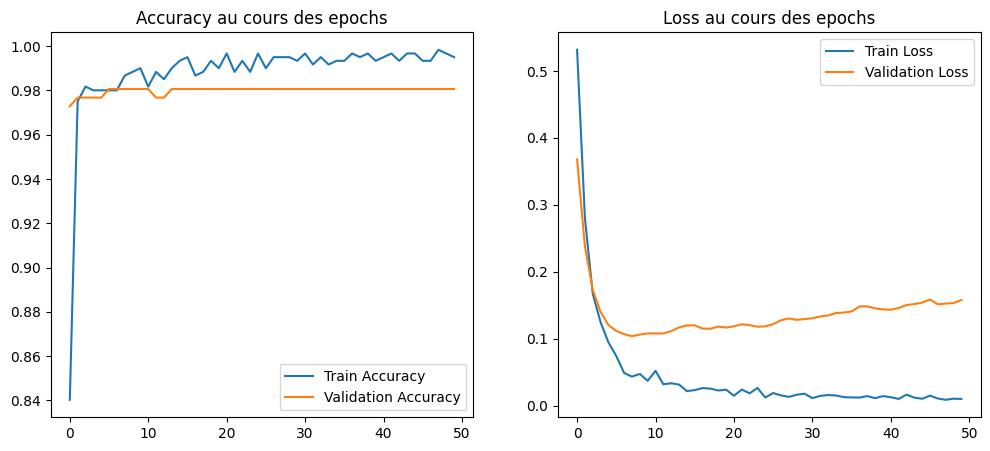

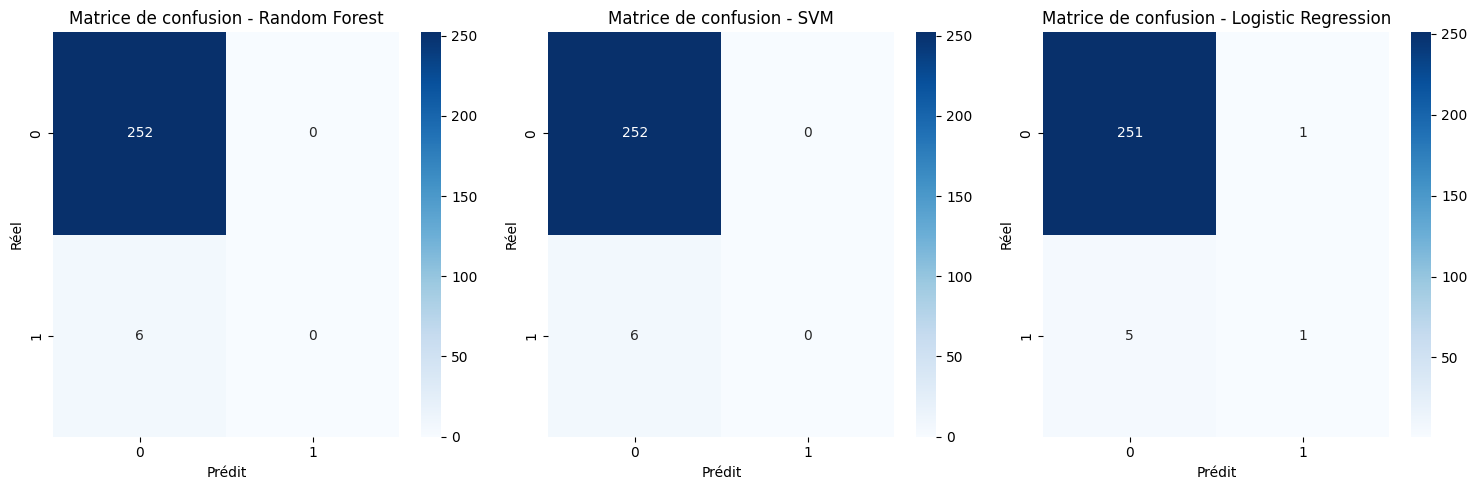

In [13]:
# Courbes d'apprentissage pour le modèle DL
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy au cours des epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss au cours des epochs')
plt.legend()
plt.show()

# Matrices de confusion pour les modèles ML
models = [('Random Forest', rf_pred), ('SVM', svm_pred), ('Logistic Regression', lr_pred)]
plt.figure(figsize=(15, 5))
for i, (name, pred) in enumerate(models, 1):
    plt.subplot(1, 3, i)
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de confusion - {name}')
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
plt.tight_layout()
plt.show()

## Évaluation des modèles

In [14]:
# Évaluation des modèles ML
print("Performances des modèles:\n")
for name, pred in models:
    print(f"=== {name} ===")
    print(classification_report(y_test, pred))
    print(f"Accuracy: {accuracy_score(y_test, pred):.4f}\n")

# Évaluation du modèle DL
dl_loss, dl_acc = model.evaluate(X_test, y_test, verbose=0)
print("=== Deep Learning Model ===")
print(f"Accuracy: {dl_acc:.4f}")
print(f"Loss: {dl_loss:.4f}")

Performances des modèles:

=== Random Forest ===
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       252
         1.0       0.00      0.00      0.00         6

    accuracy                           0.98       258
   macro avg       0.49      0.50      0.49       258
weighted avg       0.95      0.98      0.97       258

Accuracy: 0.9767

=== SVM ===
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       252
         1.0       0.00      0.00      0.00         6

    accuracy                           0.98       258
   macro avg       0.49      0.50      0.49       258
weighted avg       0.95      0.98      0.97       258

Accuracy: 0.9767

=== Logistic Regression ===
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       252
         1.0       0.50      0.17      0.25         6

    accuracy                           0.98       258
   